##     Your   Name : Mahmoud Ahmed Shawqi
##     Intake [4] AI - ITI - Smart Village

In [87]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import pmdarima as pm
import matplotlib.pyplot as plt

## read csv

In [3]:
df = pd.read_csv('DailyTotalFemaleBirths.csv', parse_dates=["Date"], index_col="Date")
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [4]:
df.isna().sum()

Births    0
dtype: int64

In [5]:
print(df.shape)

(365, 1)


## plot data

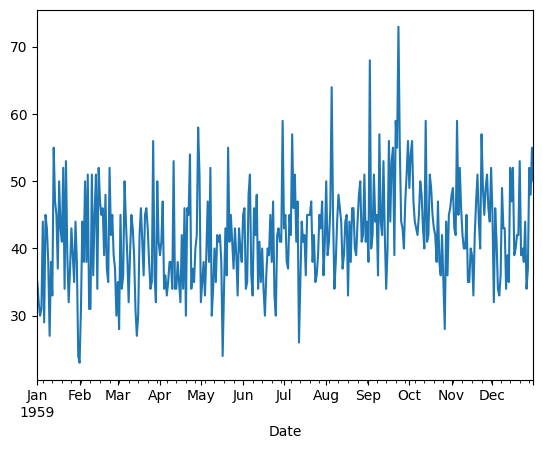

In [6]:
data = df['Births']
data.plot();

## check stationarity

In time series analysis, the assumption of stationary data refers to the idea that the statistical properties of a time series do not change over time. 

More specifically, a stationary time series is one in which the mean, variance, and autocorrelation structure are constant over time

In [7]:
result = adfuller(data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -4.808291253559765
p-value: 5.2434129901498554e-05
Critical Value (1%): -3.448748905151901
Critical Value (5%): -2.8696473721448728
Critical Value (10%): -2.5710891239349585


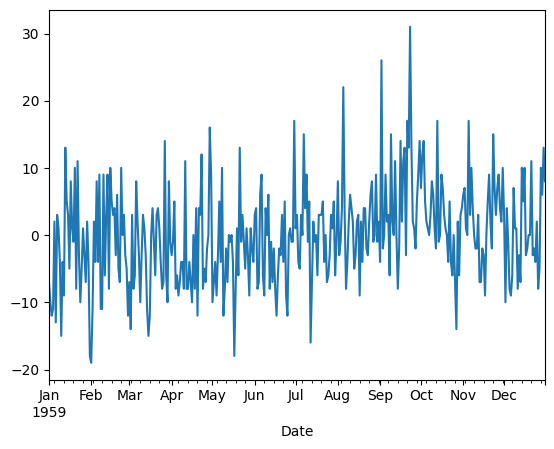

In [8]:
diff_data = data - data.mean()
diff_data.plot();

The ADF statistic is significantly lower than all critical values, suggesting strong evidence against the null hypothesis.

The p-value is very small, reinforcing the rejection of the null hypothesis.

Therefore, we can conclude that the time series data is `stationary`

## ACF

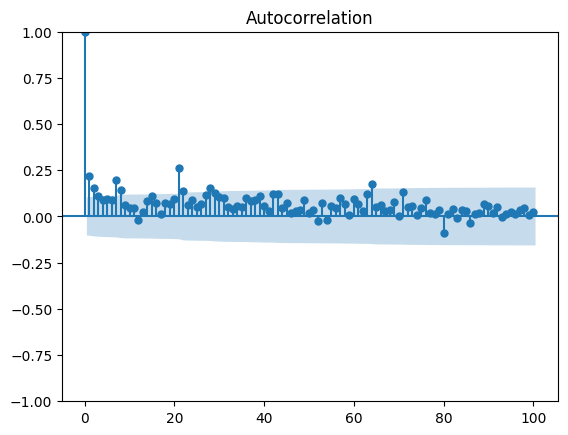

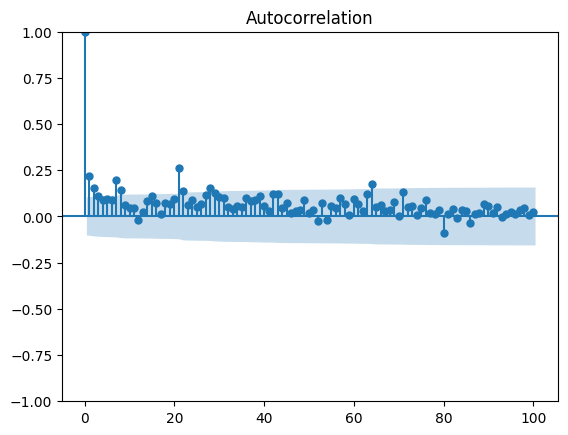

In [9]:
plot_acf(data, lags=100)

## Cut-off Pattern

## PACF

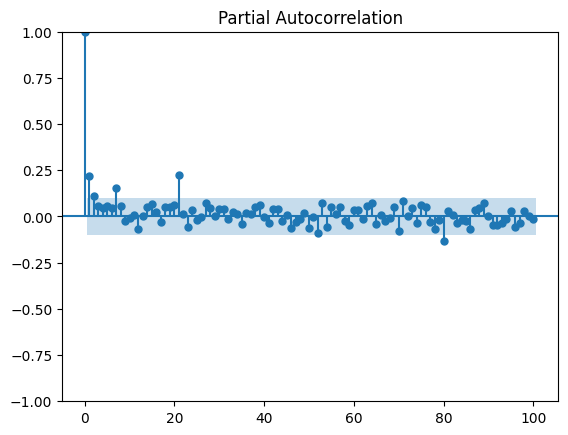

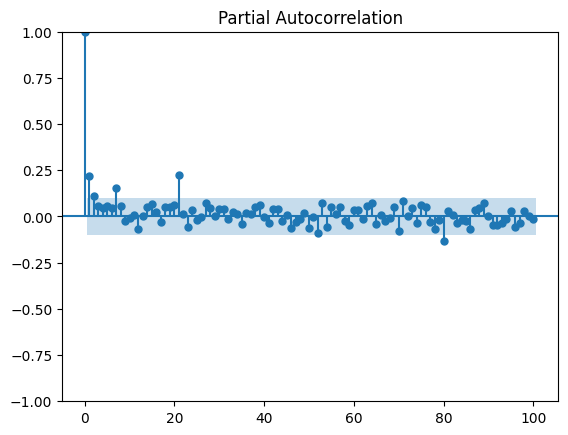

In [10]:
plot_pacf(data, lags=100)


## Cut-off Pattern

##  Applay decomposition and plot each component. 

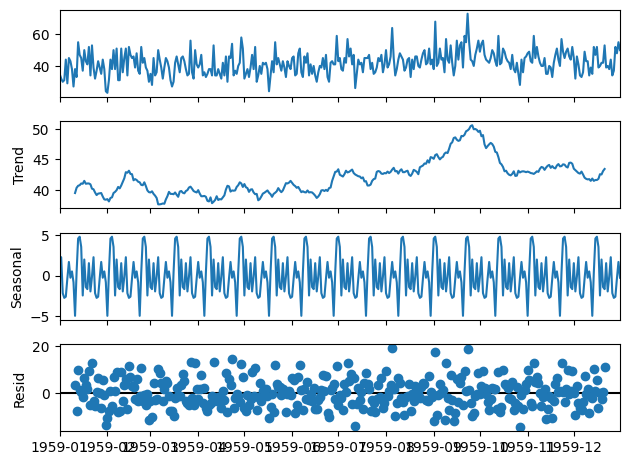

In [11]:
result = seasonal_decompose(df, model="additive", period=21)
result.plot();

## Apply the first difference and plot the data 

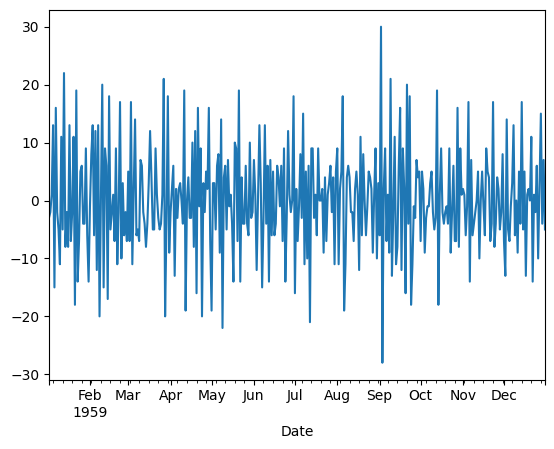

In [12]:
data_diff = data.diff().dropna()
data_diff.plot();

# split the data into 80% training and 20% testing.

In [13]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

Train size: 292
Test size: 73


In [14]:
test.head()

Date
1959-10-20    42
1959-10-21    38
1959-10-22    47
1959-10-23    38
1959-10-24    36
Name: Births, dtype: int64

## Applay 3 different ARIMA(AR,MA,ARMA,ARIMA,SARIMA) models, explain which model is best, and why.

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  292
Model:                ARIMA(21, 0, 0)   Log Likelihood                -974.595
Date:                Sun, 16 Jun 2024   AIC                           1995.190
Time:                        08:55:50   BIC                           2079.756
Sample:                    01-01-1959   HQIC                          2029.064
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.8574      1.777     23.561      0.000      38.375      45.339
ar.L1          0.1079      0.062      1.747      0.081      -0.013       0.229
ar.L2          0.0660      0.064      1.030      0.3

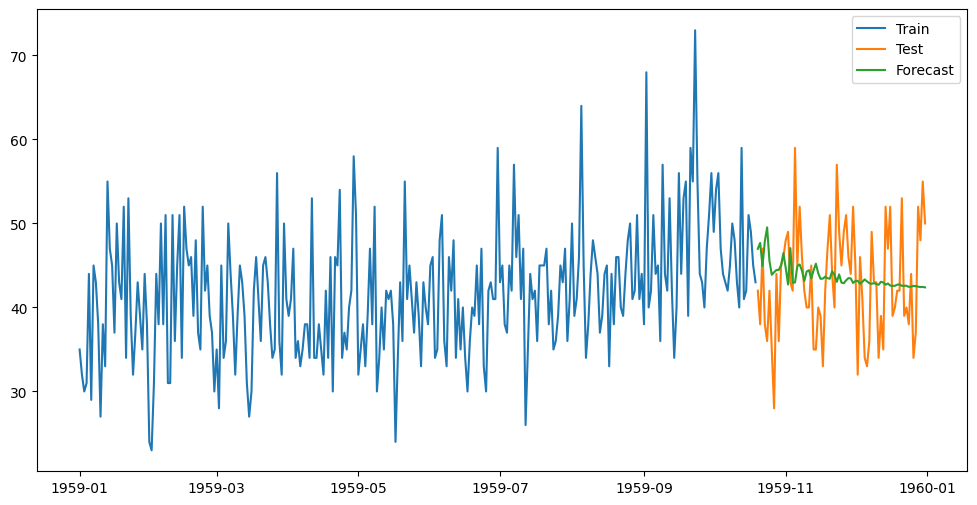

In [19]:
# AR Model (ARIMA with order=(p,0,0))
order_ar = (21, 0, 0)
model_ar = ARIMA(train, order=order_ar)
model_ar_fit = model_ar.fit()
print(model_ar_fit.summary())

# Forecast
forecast = model_ar_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  292
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -998.778
Date:                Sun, 16 Jun 2024   AIC                           2003.556
Time:                        09:06:38   BIC                           2014.586
Sample:                    01-01-1959   HQIC                          2007.974
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7178      0.538     77.550      0.000      40.663      42.772
ma.L1          0.1661      0.059      2.820      0.005       0.051       0.282
sigma2        54.7637      4.020     13.621      0.0

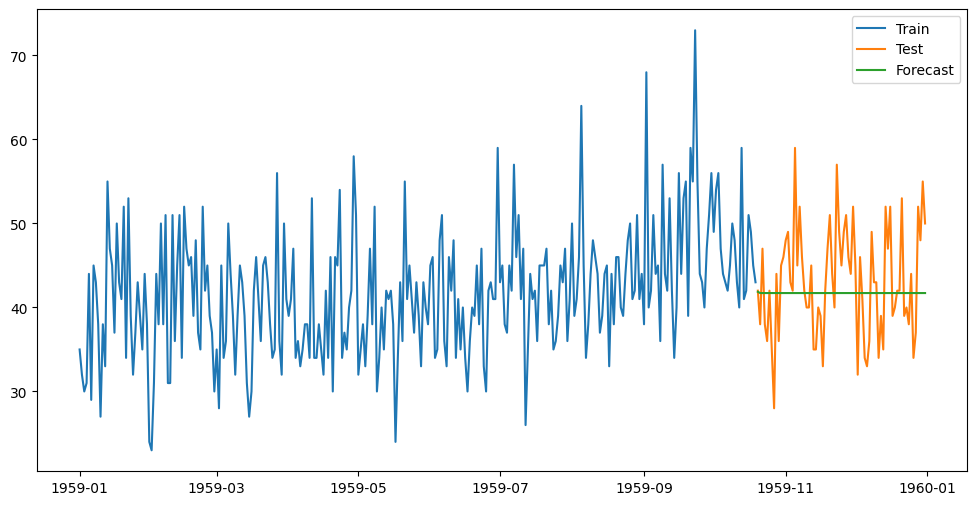

In [40]:
# MA Model (ARIMA with order=(0,0,q))
order_ma = (0, 0, 1)
model_ma = ARIMA(train, order=order_ma)
model_ma_fit = model_ma.fit()
print(model_ma_fit.summary())

# Forecast
forecast = model_ma_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  292
Model:                ARIMA(21, 0, 3)   Log Likelihood                -968.399
Date:                Sun, 16 Jun 2024   AIC                           1988.798
Time:                        08:57:52   BIC                           2084.394
Sample:                    01-01-1959   HQIC                          2027.090
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.8855      5.444      7.694      0.000      31.216      52.556
ar.L1          0.1812      0.121      1.502      0.133      -0.055       0.418
ar.L2         -0.0050      0.137     -0.037      0.9

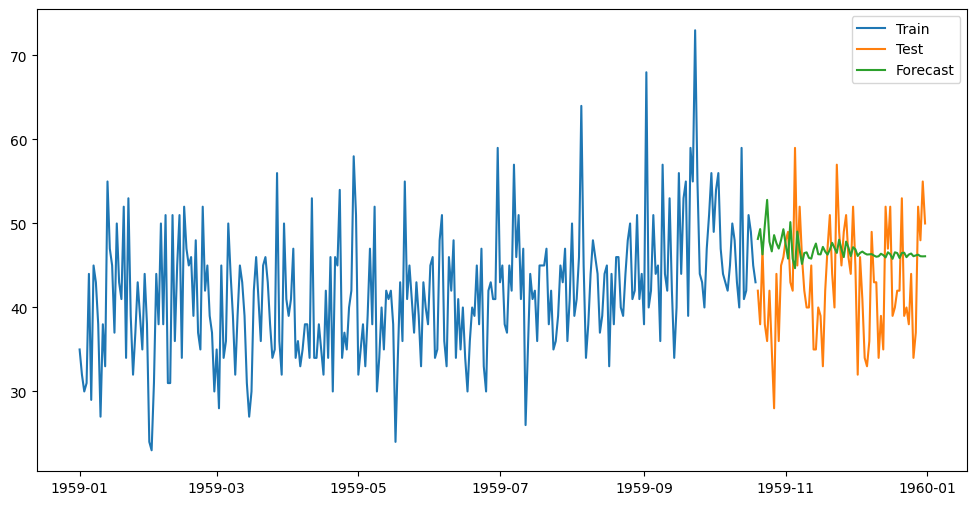

In [23]:
# ARMA Model (ARIMA with order=(p,0,q))
order_arma = (21, 0, 3)
model_arma = ARIMA(train, order=order_arma)
model_arma_fit = model_arma.fit()
print(model_arma_fit.summary())

# Forecast
forecast = model_arma_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  292
Model:                 ARIMA(5, 3, 2)   Log Likelihood               -1008.898
Date:                Sun, 16 Jun 2024   AIC                           2033.796
Time:                        09:02:38   BIC                           2063.127
Sample:                    01-01-1959   HQIC                          2045.548
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7441      0.070    -10.555      0.000      -0.882      -0.606
ar.L2         -0.5756      0.081     -7.080      0.000      -0.735      -0.416
ar.L3         -0.4415      0.083     -5.298      0.0

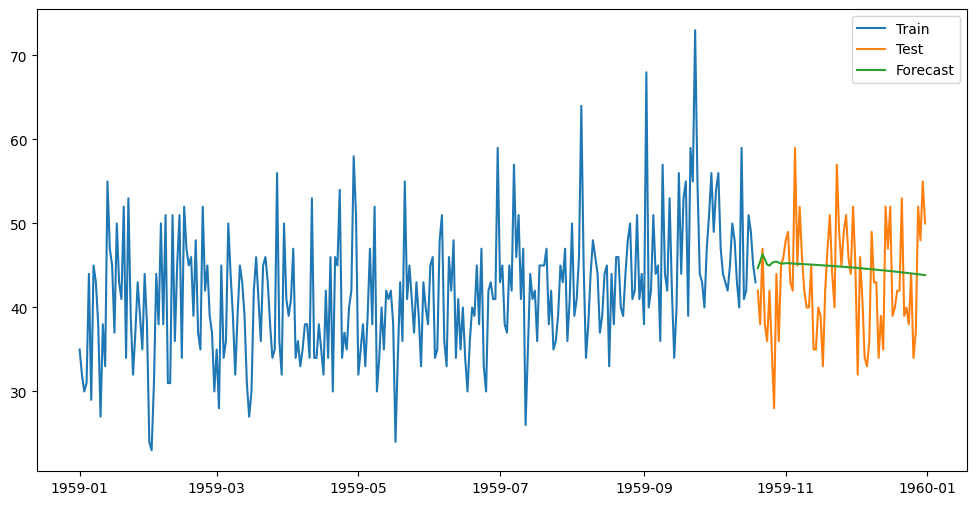

In [37]:
# ARIMA Model (ARIMA with order=(p,d,q))
order_arima = (5, 3, 2)
model_arima = ARIMA(train, order=order_arima)
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

# Forecast
forecast = model_arima_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

In [105]:
order = (7,1,0)
seasonal_order = (1, 0, 1, 21)
model = ARIMA(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Births   No. Observations:                  292
Model:             ARIMA(7, 1, 0)x(1, 0, [1], 21)   Log Likelihood                -981.538
Date:                            Fri, 14 Jun 2024   AIC                           1983.076
Time:                                    22:00:40   BIC                           2019.810
Sample:                                01-01-1959   HQIC                          1997.792
                                     - 10-19-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8297      0.062    -13.421      0.000      -0.951      -0.709
ar.L2         -0.6756      0.076   

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Births   No. Observations:                  292
Model:             ARIMA(7, 1, 0)x(1, 0, [1], 21)   Log Likelihood                -981.538
Date:                            Sun, 16 Jun 2024   AIC                           1983.076
Time:                                    09:03:26   BIC                           2019.810
Sample:                                01-01-1959   HQIC                          1997.792
                                     - 10-19-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8297      0.062    -13.421      0.000      -0.951      -0.709
ar.L2         -0.6756      0.076   

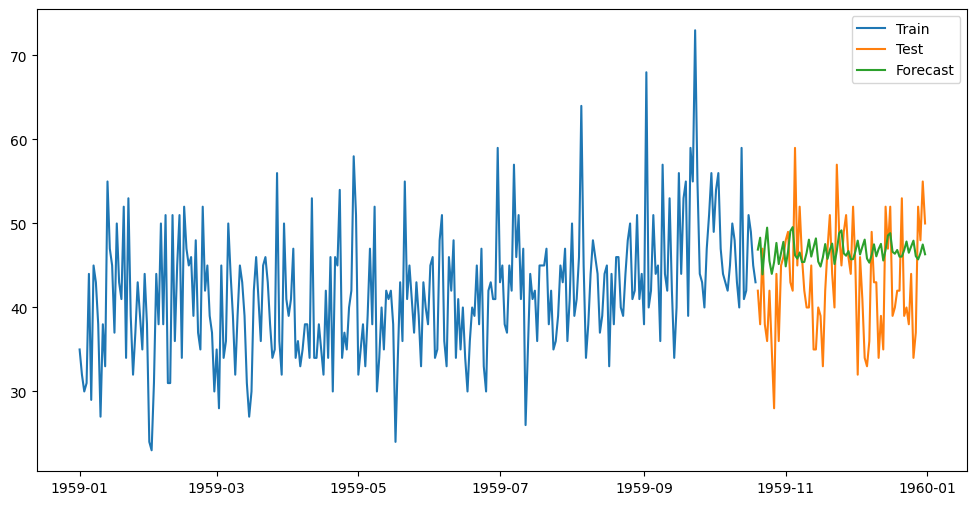

In [38]:
# SARIMA Model (ARIMA with order=(p,d,q) and seasonal_order=(P,D,Q,s))
order_sarima = (7, 1, 0)
seasonal_order_sarima = (1, 0, 1, 21)
model_sarima = ARIMA(train, order=order_sarima, seasonal_order=seasonal_order_sarima)
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())


# Forecast
forecast = model_sarima_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

In [41]:
models = {
    'AR': model_ar_fit,
    'MA': model_ma_fit,
    'ARMA': model_arma_fit,
    'ARIMA': model_arima_fit,
    'SARIMA': model_sarima_fit
}

for name, model in models.items():
    print(f'{name} - AIC: {model.aic}, BIC: {model.bic}')


AR - AIC: 1995.19044284253, BIC: 2079.7557802947003
MA - AIC: 2003.5556974377105, BIC: 2014.5859588445153
ARMA - AIC: 1988.7981776673814, BIC: 2084.3937765263568
ARIMA - AIC: 2033.7955011827335, BIC: 2063.126914687633
SARIMA - AIC: 1983.0764263707088, BIC: 2019.8096590424236


### Based on the AIC and BIC values, the SARIMA model has the lowest values, indicating a better fit. 

### Thus, SARIMA is the best model among those tested for this dataset

# APPLAY support vector regressor to predict 1 step, 3 steps, and print MSE, MAE

In [58]:
# Create lagged features
def create_lagged_features(data, n_lags):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, n_lags + 1)]
    df = pd.concat(columns, axis=1)
    df.columns = [f'lag_{i}' for i in range(1, n_lags + 1)]
    df['y'] = data
    return df.dropna()

In [59]:
n_lags = 3  # Number of lags to create
lagged_data = create_lagged_features(train, n_lags)

In [60]:
# Split the data into training and testing sets
train_size = int(len(lagged_data) * 0.8)
train_data, test_data = lagged_data[:train_size], lagged_data[train_size:]

X_train, y_train = train_data.drop('y', axis=1), train_data['y']
X_test, y_test = test_data.drop('y', axis=1), test_data['y']

In [80]:
# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Train the SVR model
svr_model = SVR(kernel='linear', C=1)
svr_model.fit(X_train_scaled, y_train_scaled)

SVR(C=1, kernel='linear')

In [81]:
# Make 1-step ahead predictions
y_pred_1_step_scaled = svr_model.predict(X_test_scaled)
y_pred_1_step = scaler_y.inverse_transform(y_pred_1_step_scaled.reshape(-1, 1)).flatten()

In [82]:
# Make 3-steps ahead predictions using a rolling forecast method
y_pred_3_steps = []
test_scaled = X_test_scaled.copy()
for i in range(len(test_scaled)):
    if i + 3 <= len(test_scaled):
        X_test_batch = test_scaled[i:i+3]
        y_pred_batch = svr_model.predict(X_test_batch)
        y_pred_3_steps.append(y_pred_batch[-1])
    else:
        y_pred_3_steps.append(svr_model.predict([test_scaled[i]])[0])

y_pred_3_steps = scaler_y.inverse_transform(np.array(y_pred_3_steps).reshape(-1, 1)).flatten()

In [83]:
# Truncate y_test to match the length of y_pred_3_steps
y_test_truncated = y_test[:len(y_pred_3_steps)]

In [84]:
# Calculate MSE and MAE for 1-step ahead predictions
mse_1_step = mean_squared_error(y_test, y_pred_1_step)
mae_1_step = mean_absolute_error(y_test, y_pred_1_step)

# Calculate MSE and MAE for 3-steps ahead predictions
mse_3_steps = mean_squared_error(y_test_truncated, y_pred_3_steps)
mae_3_steps = mean_absolute_error(y_test_truncated, y_pred_3_steps)

print(f'1-step ahead prediction - MSE: {mse_1_step}, MAE: {mae_1_step}')
print(f'3-steps ahead prediction - MSE: {mse_3_steps}, MAE: {mae_3_steps}')

1-step ahead prediction - MSE: 111.03621467366506, MAE: 7.912591722584958
3-steps ahead prediction - MSE: 118.0447607432429, MAE: 8.216925554753619


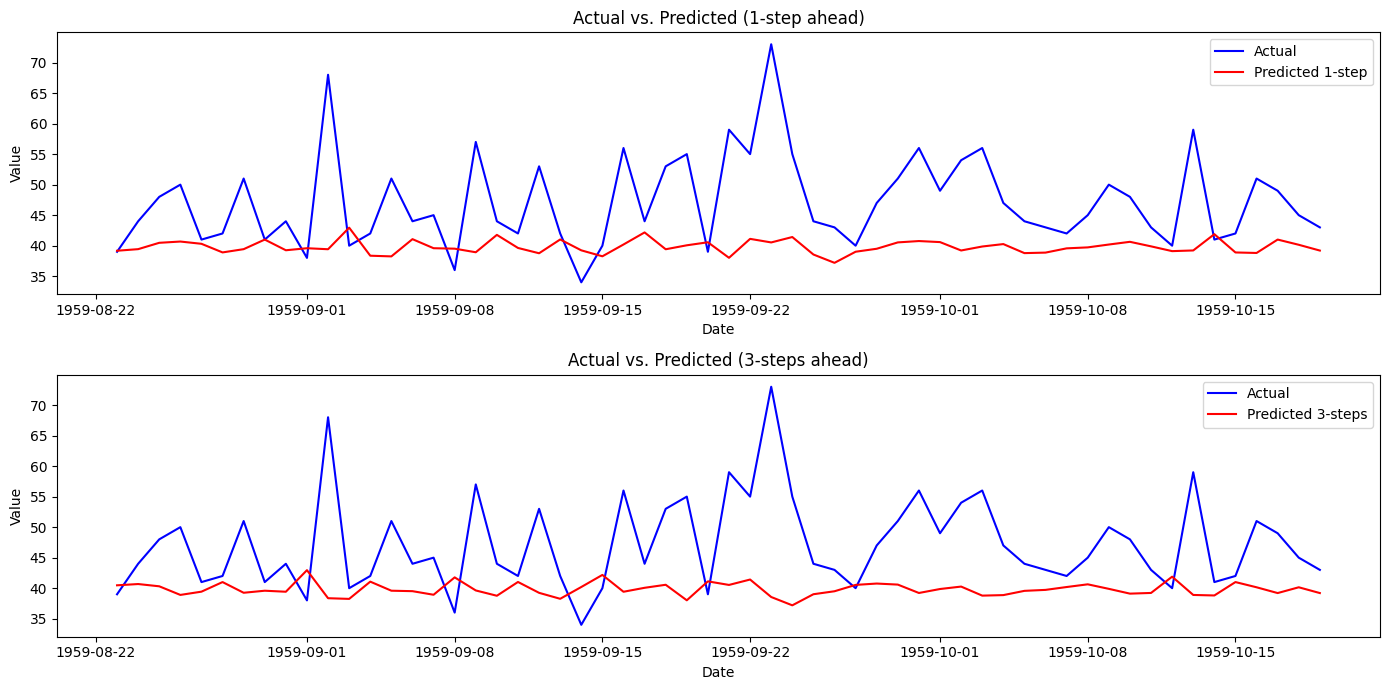

In [85]:
# Plot the results
plt.figure(figsize=(14, 7))

# 1-step ahead prediction plot
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_1_step, label='Predicted 1-step', color='red')
plt.title('Actual vs. Predicted (1-step ahead)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# 3-steps ahead prediction plot
plt.subplot(2, 1, 2)
plt.plot(y_test.index[:len(y_pred_3_steps)], y_test_truncated, label='Actual', color='blue')
plt.plot(y_test.index[:len(y_pred_3_steps)], y_pred_3_steps, label='Predicted 3-steps', color='red')
plt.title('Actual vs. Predicted (3-steps ahead)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()



## applay LSTM or RNN to predict the next step and print MSE
## Plot actual vs. prediction

In [133]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.to_numpy().reshape(-1, 1))
test_data = scaler.transform(test.to_numpy().reshape(-1, 1))

In [134]:
n_input = test.shape[0]
generator = TimeseriesGenerator(scaled_train, scaled_train, length=12, batch_size=1)

In [135]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(21, 1)))
# model.add(LSTM(50, return_sequences=True))
# model.add(LSTM(50, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 21, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
# Train the model
history = model.fit(generator, epochs=20)

Epoch 1/20
 31/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0776

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0340
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0302
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0199
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0220
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0219
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0201
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0271
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0251
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0255
Epoch 10/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0207
Epoch 11/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0209
Epoch 12/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0264
Epoch 13/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0246
Epoch 14/20
  1/280 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0027

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0234
Epoch 15/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0200
Epoch 16/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238
Epoch 17/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0215
Epoch 18/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0210
Epoch 19/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0228
Epoch 20/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0217


In [137]:
first_eval_batch = scaled_train[-2*n_input:]
test_generator = TimeseriesGenerator(first_eval_batch, first_eval_batch, length=n_input, batch_size=1)
predictions = model.predict(test_generator)

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [138]:
predictions = scaler.inverse_transform(predictions)

In [139]:
test

Date
1959-10-20    42
1959-10-21    38
1959-10-22    47
1959-10-23    38
1959-10-24    36
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: Births, Length: 73, dtype: int64

In [140]:
dates = pd.date_range(start='1959-10-20', periods=len(test), freq='D')

# Create the DataFrame
results_df = pd.DataFrame({
    'Values': test.values.flatten(),
    'Predictions': predictions.flatten(),
    'Date': dates
})

results_df = results_df.set_index('Date')

In [141]:
results_df

,Values,Predictions
Date,,
1959-10-20,42,40.812332
1959-10-21,38,41.496761
1959-10-22,47,42.534569
1959-10-23,38,43.114342
1959-10-24,36,43.146412
...,...,...
1959-12-27,37,42.555210
1959-12-28,52,42.685539
1959-12-29,48,43.482513


Text(0, 0.5, 'Value')

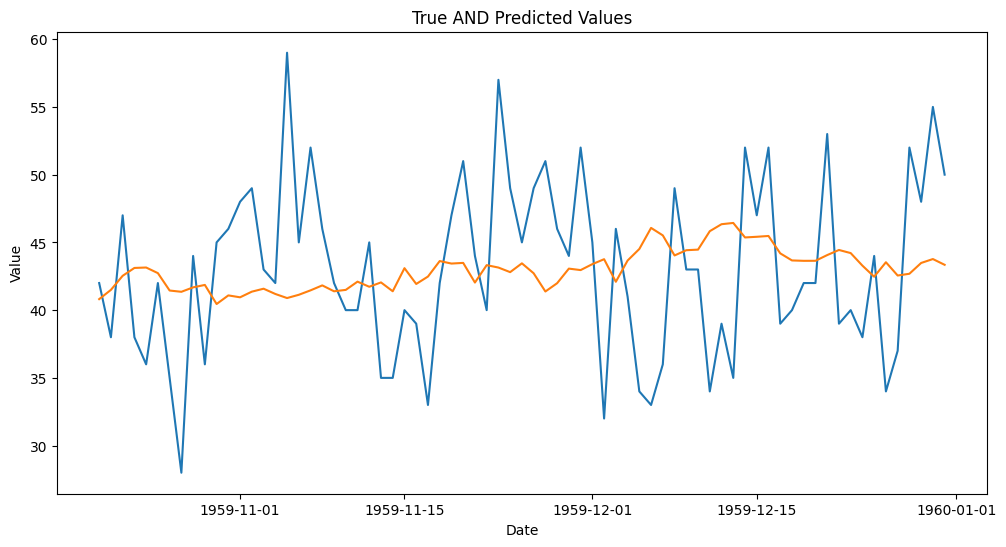

In [142]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Values'], label='True Values')
plt.plot(results_df.index, results_df['Predictions'], label='Predictions')
plt.title('True AND Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')